In [1]:
!git clone https://github.com/yama11235/my_transformerlens.git

Cloning into 'my_transformerlens'...
remote: Enumerating objects: 3979, done.
remote: Counting objects: 100% (3979/3979), done.
remote: Compressing objects: 100% (1282/1282), done.
remote: Total 3979 (delta 2676), reused 3960 (delta 2657), pack-reused 0 (from 0)
Receiving objects: 100% (3979/3979), 20.39 MiB | 7.64 MiB/s, done.
Resolving deltas: 100% (2676/2676), done.


In [2]:
cd my_transformerlens/

/content/my_transformerlens


In [3]:
pip install transformer_lens circuitsvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [4]:
!pip uninstall transformer_lens -y

Found existing installation: transformer-lens 2.6.0
Uninstalling transformer-lens-2.6.0:
  Successfully uninstalled transformer-lens-2.6.0


In [20]:
!pip install einops

# まずは軽く確率から
<paragraph>テキストを入力して各トークンの生成確率を取得してみよう</paragraph>

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2",torch_dtype=torch.float32)
model.eval()
text = """In the beginning, God created the heavens and the"""
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)


hf形式のモデルから出力トークンの生成確率を計算する場合はoutputのlogitを利用する

In [2]:
import torch
import torch.nn.functional as F

probabilities = F.softmax(output.logits[0][-1], dim=-1)

top_k = 5
top_k_probabilities, top_k_token_ids = torch.topk(probabilities, top_k)

for i in range(top_k):
    token_id = top_k_token_ids[i].item()
    token = tokenizer.decode([token_id])
    probability = top_k_probabilities[i].item()
    print(f"Token: {token}, Probability: {probability:.4f}")

Token:  earth, Probability: 0.9930
Token:  Earth, Probability: 0.0058
Token:  planets, Probability: 0.0002
Token:  moon, Probability: 0.0002
Token:  low, Probability: 0.0000


ただ、このままだとちょっと見にくい？ そんなときはTransformerLensを使おう！     ロードしたモデルをHookedTransformerモデルにoverlap

In [3]:
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer

hook_model = HookedTransformer.from_pretrained_no_processing(
    "gpt2",
    hf_model=model,
    move_to_device=True,
    device=model.device,
    dtype=torch.float32,
)

gpt2
Loaded pretrained model gpt2 into HookedTransformer


In the beginning, God created the heaves and theというプロンプトに対して次にhumanが出力される確率を調べてみる

In [8]:
from transformer_lens.utils import test_prompt

prompt = "In the beginning, God created the heavens and the"
answer = "human"

test_prompt(prompt, answer, hook_model)


Tokenized prompt: ['<|endoftext|>', 'In', ' the', ' beginning', ',', ' God', ' created', ' the', ' heavens', ' and', ' the']
Tokenized answer: [' human']


Performance on answer token:
Rank: 47       Logit: -71.79 Prob:  0.00% Token: | human|

Top 0th token. Logit: -59.16 Prob: 99.32% Token: | earth|
Top 1th token. Logit: -64.34 Prob:  0.56% Token: | Earth|
Top 2th token. Logit: -67.60 Prob:  0.02% Token: | planets|
Top 3th token. Logit: -68.00 Prob:  0.01% Token: | moon|
Top 4th token. Logit: -68.73 Prob:  0.01% Token: | heavens|
Top 5th token. Logit: -69.13 Prob:  0.00% Token: | oceans|
Top 6th token. Logit: -69.37 Prob:  0.00% Token: | ten|
Top 7th token. Logit: -69.39 Prob:  0.00% Token: | stars|
Top 8th token. Logit: -69.42 Prob:  0.00% Token: | seas|
Top 9th token. Logit: -69.45 Prob:  0.00% Token: | four|


Ranks of the answer tokens: [(' human', 47)]

test_promptを使用すると、promptと予測単語のトークナイズ結果、予測tokenの生成確率や予測Top 10 tokenが表示される

次は全体の文章がどの程度出力されやすいかを見てみよう

cv.logits.token_log_probsメソッドに、トークン列、トークンの確率、テキストを入力すると文章の生成確率を可視化できる。テキスト・トークン間の変換や確率はhook_modelのメソッドでもできる
赤いトークンほど出力されやすい。また、各トークンの次のtop-10-tokenも分かる

In [9]:
import circuitsvis as cv  # optional dep, install with pip install circuitsvis

# Let's make a longer prompt and see the log probabilities of the tokens
example_prompt = """Waseda University, abbreviated as Waseda or Sōdai, is a private research university in Shinjuku, Tokyo.
                    Founded in 1882 as the Tōkyō Professional School by Ōkuma Shigenobu, the fifth Prime Minister of Japan, the school was formally renamed Waseda University in 1902.[4]"""
logits, cache = hook_model.run_with_cache(example_prompt)
cv.logits.token_log_probs(
    hook_model.to_tokens(example_prompt),
    hook_model(example_prompt)[0].log_softmax(dim=-1),
    hook_model.to_string,
)

#HookedTransformerの仕組みについて

次はmodelのhidden_statesを取得してみよう

In [10]:
example_prompt = """In the beginning, God created the heavens and the"""
hidden_states = model(hook_model.to_tokens(example_prompt),output_hidden_states=True).hidden_states

In [11]:
print(len(hidden_states))
print(hidden_states[0].shape)

13
torch.Size([1, 11, 768])


hf形式のモデルのforward関数から得られるhidden_statesは各Transformerブロックの出力とlm_headを通る前の出力を返すようになっている
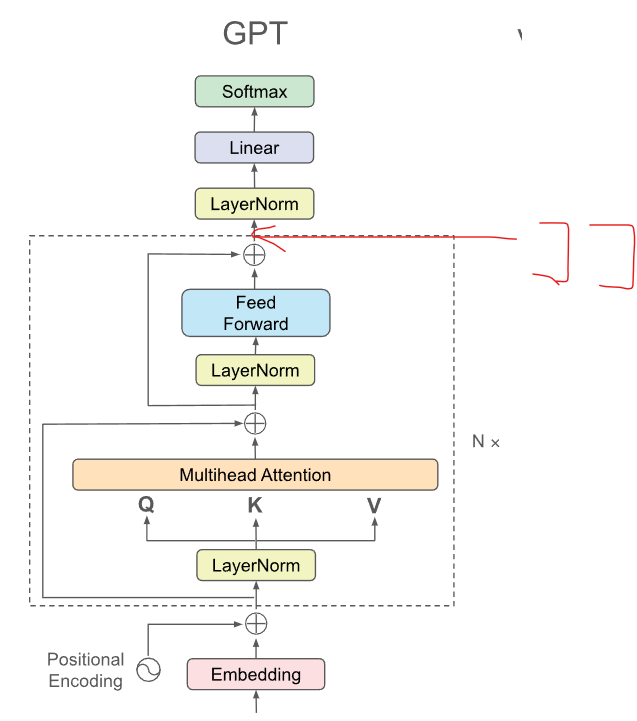

feedforward層の出力のhidden_statesを取り出したい...そんなときはTransformerLensを使おう!
run_with_cacheメソッドを使用するとあらゆる箇所のhidden_stateを取得できる

In [12]:
logits, cache = hook_model.run_with_cache(example_prompt)

In [13]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

例えば10層目のmlp層の出力のhidden_statesを取り出したいときは、

In [14]:
cache["blocks.9.hook_mlp_out"].shape

torch.Size([1, 11, 768])

これを使うとlogit lens的なことができる

In [15]:
#example_prompt = """In the beginning, God created the heavens and the"""

for layer_num in range(12):
    mlp_output = model.lm_head(cache[f"blocks.{layer_num}.hook_mlp_out"][0,-1,:]).softmax(dim=-1)

    top_k = 5
    top_k_probabilities, top_k_token_ids = torch.topk(mlp_output, top_k)

    for i in range(top_k):
        token_id = top_k_token_ids[i].item()
        token = tokenizer.decode([token_id])
        probability = top_k_probabilities[i].item()
        print(f"Token: {token}, Probability: {probability:.4f}, layer: {layer_num}")
    print("-"*50)

Token:  first, Probability: 0.4587, layer: 0
Token:  ", Probability: 0.1402, layer: 0
Token:  same, Probability: 0.1055, layer: 0
Token:  the, Probability: 0.0585, layer: 0
Token:  most, Probability: 0.0465, layer: 0
--------------------------------------------------
Token:  "\, Probability: 0.0009, layer: 1
Token:  smallest, Probability: 0.0008, layer: 1
Token: atre, Probability: 0.0005, layer: 1
Token: ugu, Probability: 0.0005, layer: 1
Token: ogether, Probability: 0.0005, layer: 1
--------------------------------------------------
Token:  Oath, Probability: 0.0023, layer: 2
Token:  following, Probability: 0.0014, layer: 2
Token:  usual, Probability: 0.0011, layer: 2
Token:  Essential, Probability: 0.0009, layer: 2
Token:  entry, Probability: 0.0009, layer: 2
--------------------------------------------------
Token: abase, Probability: 0.0076, layer: 3
Token: DN, Probability: 0.0039, layer: 3
Token: ril, Probability: 0.0032, layer: 3
Token: quickShipAvailable, Probability: 0.0032, la

なぜこのようなことが出来るのかというと、HookedTransformerは元々のモデルの全てのモジュールの前後にアクセスできるようにモデルを改変する

In [16]:
hook_model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_re

このHookPoint()に各モジュールの入出力の値が渡されるので、内部表現を自在に取得できる

また、先ほどのcvライブラリを使うとattention patternも可視化できる

In [17]:
text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
tokens = hook_model.to_tokens(text)

logits, cache = hook_model.run_with_cache(tokens, remove_batch_dim=True)

attention_pattern = cache["pattern", 0, "attn"]
print(attention_pattern.shape)
str_tokens = hook_model.to_str_tokens(text)

print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

torch.Size([12, 33, 33])
Layer 0 Head Attention Patterns:


#モデルの内部計算に介入しよう

モジュールの前後にアクセスできるということは、モデルの内部計算に介入できるということでもある。適当なモジュールをablationしてみよう。ここではランダムなトークンで繰り返しの文章を入力してみる

In [4]:
import einops
batch_size = 1
seq_len = 25
size = (batch_size, seq_len)
input_tensor = torch.randint(1000, 10000, size)

random_tokens = input_tensor.to(hook_model.cfg.device)
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")

In [5]:
text = tokenizer.batch_decode(repeated_tokens)[0]
text

' movies exists changico Chicago Becausecont Planaa ManagerIf Drive Trade unless campaigns ran�� subsequ residentsources tor books heavyHzview movies exists changico Chicago Becausecont Planaa ManagerIf Drive Trade unless campaigns ran�� subsequ residentsources tor books heavyHzview'

In [7]:
import circuitsvis as cv
logits, cache = hook_model.run_with_cache(text)
cv.logits.token_log_probs(
    hook_model.to_tokens(text),
    hook_model(text)[0].log_softmax(dim=-1),
    hook_model.to_string,
)

In [9]:
attention_pattern = cache["pattern", 5, "attn"]
str_tokens = hook_model.to_str_tokens(text)

print("Layer 5 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

Layer 5 Head Attention Patterns:


In [19]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm

from jaxtyping import Float
from functools import partial
# import transformer_lens
import transformer_lens.utils as utils

layer_to_ablate = 5


# We define a head ablation hook
# The type annotations are NOT necessary, they're just a useful guide to the reader
#
def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    print(f"Shape of the value tensor: {value.shape}")
    value[:, :, 0, :] = 0
    value[:, :, 1, :] = 0
    value[:, :, 5, :] = 0
    return value

original_loss = hook_model(text, return_type="loss")
ablated_logits, ablated_loss = hook_model.run_with_hooks(
    text,
    return_type="both",
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate),
        head_ablation_hook
        )]
    )
print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

Shape of the value tensor: torch.Size([1, 53, 12, 64])
Original Loss: 6.330
Ablated Loss: 7.281


In [20]:
cv.logits.token_log_probs(
    hook_model.to_tokens(text),
    ablated_logits.log_softmax(dim=-1),
    hook_model.to_string,
)